In [1]:
from mpl_toolkits import mplot3d

In [2]:
# %matplotlib notebook --doesnt seem to work in colab
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

# Helper functions

## Lattice generator

In [ ]:

# To rotate the primary hexagonal vectors
def vector_rotate(vector, angle, notat='deg'):
  '''
  rotates given vector clockwise by the given angle
  '''
  if notat == 'deg':
    angle = angle* np.pi/180

  rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                              [np.sin(angle), np.cos(angle)]])
  vector = rotation_matrix @ vector

  return vector

# To generate the lattice
def lattice_generator(orientation, lam, m_n, notat='deg'):
  '''
  Orientation: Angle in degrees or radians
  lam: Spatial period of the hexagonal lattice
  m_n: multiples of 
  '''
# primary basis vectors  
  v_initial = np.array([0.5, np.sqrt(3)/2])
  u_initial = np.array([1, 0])
  print("Primary vectors:", v_initial, u_initial)

# rotated basis vectors
  v = vector_rotate(v_initial, orientation, notat)
  u = vector_rotate(u_initial, orientation, notat)
  print("Rotated Vectors:", v, u)
# create 2-D array to fill positions of lattice vertices: m_n**2 rows of (x,y) values
  array = np.zeros((m_n**2, 2))

  m = np.arange(1, m_n+1)
  iterator = 0

  for i in m:
  #  print(i)
    for j in m:

      array[iterator] = lam*((i)*v + (j)*u)
      iterator += 1

  #print(array)
  return array, lam, orientation

# plot the 2-D lattice array
def lattice_plot(array, lam, orientation):
  
  x = array[:,0]
  y = array[:,1]

 # print("x", x)
 # print("y", y)

  plt.figure(dpi=150)
  plt.plot(x, y, '.')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.title("Orienation: " + str(orientation) + ", Lambda = " + str(lam) )
  plt.show()



Primary vectors: [0.5       0.8660254] [1 0]
Rotated Vectors: [0.5       0.8660254] [1. 0.]


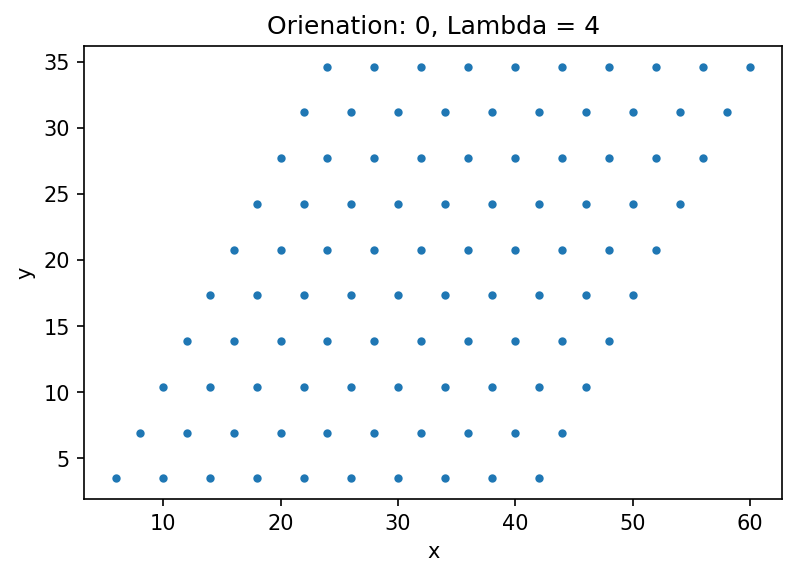

In [ ]:
lam = 4
orientation = 0
lattice, lam, orien = lattice_generator(orientation, 4, 10)
lattice_plot(lattice, lam, orien)

## Gaussian Firing Field Generator

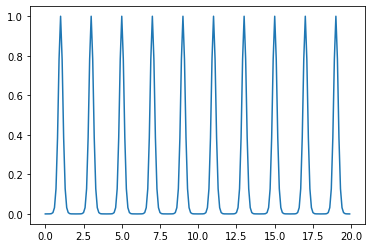

In [ ]:
# von Mises tuning curve:

def vonMises(x,lam, c, k, b, a=0):
  ''' 1-D vonMises Tuning Curve
  
  '''
  return a + b*np.exp(k*(np.cos(np.pi*(x - c)/lam) - 1))

c = 1
k = 5
a = 0
b = 1
lam = 1

y = np.arange(0,20, 0.1)
plt.plot(y, vonMises(y, lam, c, k, b, a=a))

In [ ]:
def vonMisesTuning(x, args):
  '''
  x: 2-D vector for position coordinates
  args: n_max; K; lamda

  returns: (scalar) value of the vonMises 
          tuning curve at the given position coordinates
  '''
  pi = np.pi 

  k1 = np.array([np.cos(pi/6), np.sin(pi/6)])
  k2 = np.array([np.cos(pi/2), np.sin(pi/2)])
  k3 = np.array([np.cos(pi*5/6), np.sin(pi*5/6)])
  plane_vectors = np.vstack((k1, k2, k3))

  lam = args['lam'] # lamda, the spatial period
  w = (2*pi)/(np.sin(pi/3)*lam) # omega, for the periodicity of the tuning function
  n_max = args['n_max'] # maximum firing frequency of the tuning curve
  K = args['K'] # kappa, for the tuning-width

  dot_prod = w * plane_vectors @ x.T # the dot product of the plane vector with the position coordinate done for all three vectors
  tuning_curve = n_max * np.exp((K/3) * np.sum(np.cos(dot_prod) - 1))

  return tuning_curve

def plot_3D(x, y, z, title):
  '''
  Parameters:
  x: 1-D array of x values
  y: 1-D array of y values
  z: 2-D array of z values
  title: type(str)

  Plots the given data in 3D
  '''
  X,Y = np.meshgrid(x,y)
  fig = plt.figure() # initialize plot
  ax = plt.axes(projection='3d')


  ax.plot_surface(X, Y,z)

  ax.set_title(title)
  plt.show()

def tuning_generator(x_range, y_range, step_size, args, verbose=False):
  x = np.arange(0, x_range, step_size)
  y = np.arange(0, y_range, step_size)

  result = np.zeros((int(x_range/step_size), int(y_range/step_size)))
  iteration = 1

  for x_idx, i in enumerate(x):
    for y_idx, j in enumerate(y):
      # goes through each x and y value and store the vonMises value in the 2-D array 'result'
      position = np.array([i,j])
      result[x_idx, y_idx] = vonMisesTuning(position, args)
      if verbose == True:
        print('Iteration:', iteration)
      iteration += 1

  return x, y, result


In [ ]:
args = {'lam': 2,
        'n_max': 20,
        'K': 2}

x, y, tuning = tuning_generator(x_range=10, y_range=10, step_size=0.1, args=args)

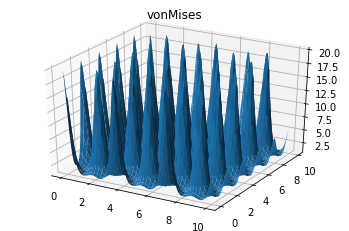

In [ ]:

plot_3D(x, y, tuning, 'vonMises')


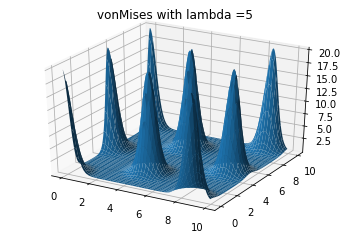

In [ ]:
args = {'lam': 5,
        'n_max': 20,
        'K': 5}

x, y, tuning = tuning_generator(x_range=10, y_range=10, step_size=0.05, args=args)
plot_3D(x, y, tuning, 'vonMises with lambda =' + str(args['lam']))

## Intialize Trajectory & Compute Firing Rate

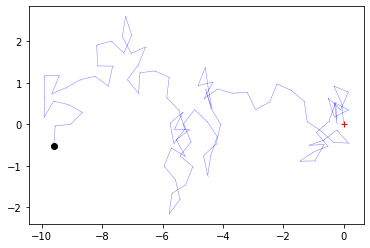

In [ ]:
def random_trajectory(total_steps =100,step_size=0.5):
    '''plots & returns n*2 array of randomly generated postions'''
    angle = np.random.rand(total_steps)*2*np.pi
    x = step_size*np.hstack((0, np.cos(angle)))
    y = step_size*np.hstack((0, np.sin(angle)))
    traject=np.column_stack((x,y)).cumsum(0)
    start = traject[0,:]
    stop = traject[-1,:]

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(traject[:,0], traject[:,1],c='blue',alpha=0.25,s=0.05);
    ax.plot(traject[:,0], traject[:,1],c='blue', alpha=0.5,lw=0.5,ls='-')
    ax.plot(start[0], start[1],c='red', marker='+')
    ax.plot(stop[0], stop[1],c='black', marker='o')
    plt.show()
    return traject

def compute_firing_rate(traject,cells):
    '''traject: n*2 array of positions, 
    cells:list of dicts defining each cell
    returns n*n array where first axis is cells and second axis is time
    '''
    firing_rates = np.zeros([len(cells),traject[:,0].size])
    for i,cell in enumerate(cells):
        for j,pos in enumerate(traject):
            firing_rates[i,j]=vonMisesTuning(pos, cell)
    return firing_rates       
    
traject=random_trajectory()

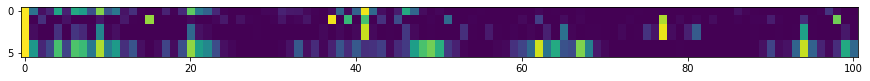

In [ ]:
#initalize cells
args_ = ['lam','n_max','K']
cells = []
for n in range(6):
  cells.append({args_[0]:np.random.randint(1,6),args_[1]:20,args_[2]:5})


firings = compute_firing_rate(traject,cells)
plt.figure(figsize=(15,15))
plt.imshow(firings)
plt.show()

In [ ]:
print(cells)

[{'lam': 4, 'n_max': 20, 'K': 5}, {'lam': 1, 'n_max': 20, 'K': 5}, {'lam': 2, 'n_max': 20, 'K': 5}, {'lam': 2, 'n_max': 20, 'K': 5}, {'lam': 5, 'n_max': 20, 'K': 5}, {'lam': 5, 'n_max': 20, 'K': 5}]


Cell no: 0


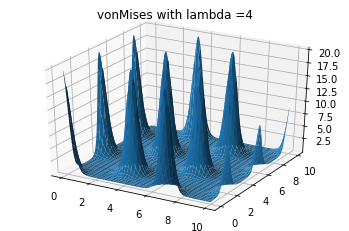

Cell no: 1


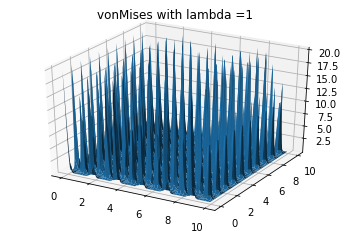

Cell no: 2


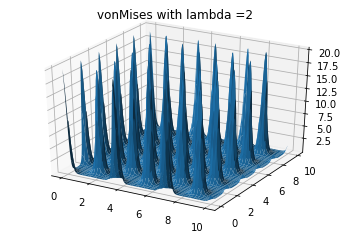

Cell no: 3


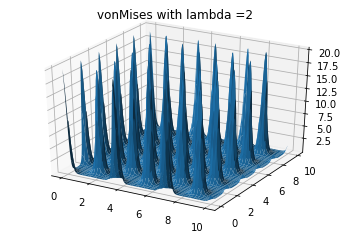

Cell no: 4


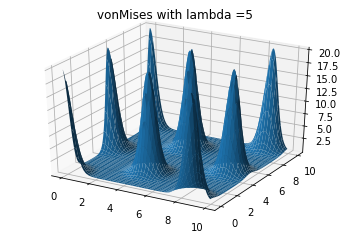

Cell no: 5


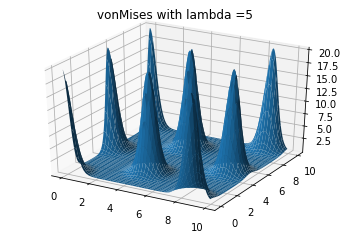

In [ ]:
#@title Tuning Curves of Cells
for idx, cell_args in enumerate(cells):
  print("Cell no:", idx)
  x, y, tuning = tuning_generator(x_range=10, y_range=10, step_size=0.05, args=cell_args)
  plot_3D(x, y, tuning, 'vonMises with lambda =' + str(cell_args['lam']))

In [ ]:
#@title Straight Trajectory
# straight line, parallel to x-axis
def straight_x(x_range, y_value, step_size):
  line_traject_x = np.arange(0, x_range, step_size)
  line_traject_y = y_value*np.ones_like(line_traject_x)
  line_traject = np.vstack((line_traject_x, line_traject_y)).T

  return line_traject


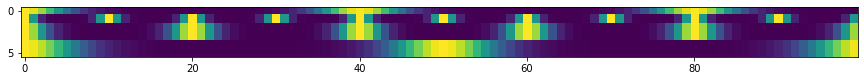

In [ ]:
straight_line = straight_x(10, 0, 0.1)
firing_straight = compute_firing_rate(straight_line, cells)
plt.figure(figsize=(15,15))
plt.imshow(firing_straight)
plt.show()

In [ ]:
def poisson_train_generator(lam, time_steps):
  

## Population Vector Decoding



In [ ]:
def vonMisesTuning(x, args):
  '''
  x: 2-D vector for position coordinates
  args: n_max; K; lamda

  returns: (scalar) value of the vonMises 
          tuning curve at the given posi
          tion coordinates
  '''
  pi = np.pi   
  k1 = np.array([np.cos(pi/6), np.sin(pi/6)])
  k2 = np.array([np.cos(pi/2), np.sin(pi/2)])
  k3 = np.array([np.cos(pi*5/6), np.sin(pi*5/6)])
  plane_vectors = np.vstack((k1, k2, k3))  
  lam = args[ids['lam']] # lamda, the spatial period
  w = (2*pi)/(np.sin(pi/3)*lam) # omega, for the periodicity of the tuning function
  n_max = args[ids['n_max']] # maximum firing frequency of the tuning curve
  K = args[ids['K']] # kappa, for the tuning-width
  phase = args[ids['phase']]
  phase_dir = args[ids['phase_dir']]
  c =  ((phase*lam)/(2*pi))
  c_vec = c*plane_vectors[int(phase_dir)]

  dot_prod = w * plane_vectors @ (x-c_vec).T # the dot product of the plane vector with the position coordinate done for all three vectors
  tuning_curve = n_max * np.exp((K/3) * np.sum(np.cos(dot_prod) - 1))

  return tuning_curve


def random_trajectory(total_steps =100,step_size=0.5):
    '''plots & returns n*2 array of randomly generated postions'''
    angle = np.random.rand(total_steps)*2*np.pi
    x = step_size*np.hstack((0, np.cos(angle)))
    y = step_size*np.hstack((0, np.sin(angle)))
    traject=np.column_stack((x,y)).cumsum(0)
    start = traject[0,:]
    stop = traject[-1,:]

def trajectory_1(total_steps =10):
    '''plots & returns n*2 array of randomly generated postions'''
   
    x=np.random.uniform(low=0, high=6, size=total_steps)
    y =np.random.uniform(low=0, high=6, size=total_steps)
    traject=np.column_stack((x,y))
    start = traject[0,:]
    stop = traject[-1,:]


#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.scatter(traject[:,0], traject[:,1],c='blue',alpha=0.25,s=0.05);
#     ax.plot(traject[:,0], traject[:,1],c='blue', alpha=0.5,lw=0.5,ls='-')
#     ax.plot(start[0], start[1],c='red', marker='+')
#     ax.plot(stop[0], stop[1],c='black', marker='o')
#     plt.show()
    return traject

def compute_firing_rate(traject,cells):
    '''traject: n*2 array of positions, 
    cells:list of dicts defining each cell
    returns n*n array where first axis is cells and second axis is time
    '''
    firing_rates = np.zeros([len(cells),len(cells[0,:]),traject[:,0].size])
    for m in range(len(cells)):
        for i in range(len(cells[0,:])):
            for j,pos in enumerate(traject):
                firing_rates[m,i,j]=vonMisesTuning(pos, cells[m,i])
    return firing_rates     


def population_decoder(firings,module):
  '''firings:n*1 (cells*t) firing vector for one module at t 
     module: n*n (cells*properties), numpy array defining cells of each module)
     '''  
  pi = np.pi 
  k1 = np.array([np.cos(pi/6), np.sin(pi/6)])
  k2 = np.array([np.cos(pi/2), np.sin(pi/2)])
  k3 = np.array([np.cos(pi*5/6), np.sin(pi*5/6)])
  plane_vectors = np.vstack((k1, k2, k3))
  phases = module[:,ids['phase']]
  lams = module[:,ids['lam']]
  K = module[:,ids['K']][0]
  w = (2*pi)/(np.sin(pi/3)*lams[0]) 
  #calculate cj's
  c =   (phases*lams)/(2*pi)
  c_all = np.zeros(shape=(len(c),2))
  for i,val in enumerate(c):
    c_all[i] = val*plane_vectors[int(module[i,ids['phase_dir']])]
  mu_l = np.zeros(3)
  k_hat = np.zeros_like(mu_l)  
  for i in range(len(mu_l)):
        dotp=plane_vectors[i]@c_all.T
        #print(dotp)
        #print(np.sum(firings*np.exp(1j*w*dotp)))
        mu_l[i]=(np.angle(np.sum(firings*np.exp(1j*w*dotp))))/w
        #print((firings[:,0]*np.exp(1j*w*dotp)).shape)
        k_hat[i]= (K/3)*np.sum(firings*np.cos(w*(plane_vectors[i]@(plane_vectors[i]*mu_l[i]-c_all).T)))
    

  x_ml = (2/3)*(mu_l@plane_vectors)
  return x_ml

def mec_decoder(firings,cells):
    position_estimates = np.zeros(shape=(len(cells),2))
    for i,modules in enumerate(cells):
        position_estimates[i]=population_decoder(firings[i,:],modules)
    return position_estimates

def trajctory_decoder(traject,firings,cells):
    trajectory_estimate = np.zeros(shape=(len(cells),len(traject),2))
    for t in range(len(traject)):
        trajectory_estimate[:,t,:]=mec_decoder(firings[:,:,t],cells)
    return trajectory_estimate    
        



def mec_dec_1(firings,cells):
    delms = np.zeros(shape=(len(cells),2))
    sm = np.zeros(len(cells))
    l0 =cells[-1,0,ids['lam']]
    for i in range(len(cells)-1,-1,-1):
        delms[i] = population_decoder(firings[i,:,0],cells[i])
        sm[i] = l0/cells[i,0,ids['lam']]
    p=np.zeros_like(delms)
    for i in range(len(sm)):
        p[i]=(sm[i]**2)*delms[i]
    return (np.sum(p,axis=0)*len(cells[0,:]))/(np.sum((sm**2))*len(cells[0,:]))

def mec_dec_2(firings,cells):
    del_vec = population_decoder(firings[-1,:,0],cells[-1])
    sm = np.zeros(len(cells))
    l0 =cells[-1,0,ids['lam']]
    for i in range(len(cells)-1,-1,-1):
        delms[i] = population_decoder(firings[i,:,0],cells[i])
        sm[i] = l0/cells[i,0,ids['lam']]
    p=np.zeros_like(delms)
    for i in range(len(sm)):
        p[i]=(sm[i]**2)*delms[i]
    return (np.sum(p,axis=0)*len(cells[0,:]))/(np.sum((sm**2))*len(cells[0,:]))


def population_decode_xn(firings,cells):
    x0=population_decoder(firings[-1,:,0],cells[-1])
    print(x0)
    n_cells = len(cells[0,:])
    lams = cells[:,0,ids['lam']]
    for i in range(len(cells)-2,-1,-1):
        xi = population_decoder(firings[i,:,0],cells[i])
        delm = xi-x0
        x0 = x0 + ((n_cells/(lams[i+1]**2))/(n_cells*np.sum(1/(lams[-1:i-len(cells)-1:-1]**2))))*delm
        print(delm)
    return x0


In [ ]:
#initalize cells

global ids
ids = {'lam': 0,
        'n_max': 1,
        'K': 2,'phase':3,'phase_dir':4,'ori':5}

n_module=10
n_cells = 361

cells = np.zeros(shape=(n_module,n_cells,len(ids)))

lams  = np.hstack((np.array([0.36,0.50,0.70,1]),np.full(n_module-4,np.sqrt(2)).cumprod(0)))

for i in range(1,n_module+1):
    cells[i-1,:,ids['lam']] = lams[i-1]
    cells[i-1,:,ids['n_max']] =4
    cells[i-1,:,ids['K']] =100/cells[i-1,:,ids['lam']] 
    phases = np.linspace(0,2*np.pi,(n_cells+2)//3)
    cells[i-1,:,ids['phase']]= np.hstack((phases[0],phases[1:],phases[1:],phases[1:]))
    cells[i-1,:,ids['phase_dir']] = np.hstack((np.zeros(len(phases)),np.ones(len(phases[1:])),np.full(len(phases[1:]), 2)))
    cells[i-1,:,ids['ori']] =1
    

NameError: ignored

In [ ]:
# traject=trajectory_1(total_steps=5)
traject = np.array([[0.4,0.5]])
firings = compute_firing_rate(traject,cells)
estimated_trajectory=trajctory_decoder(traject,firings,cells)

In [ ]:

population_decode_xn(firings,cells)

In [ ]:
def vonMises(x,cell,a=0):
    ''' 1-D vonMises Tuning Curve'''
    lam = cell[ids['lam']]
    phase = cell[ids['phase']]
    k = cell[ids['K']]
    c = (lam*phase)/(2*np.pi)
    b=cell[ids['n_max']]
    return a + b*np.exp(k*(np.cos(np.pi*(x - c)/lam) - 1))


global ids
ids = {'lam': 0,
        'n_max': 1,
        'K': 2,'phase':3}

n_module=10
n_cells = 64

cells = np.zeros(shape=(n_module,n_cells,len(ids)))

l = np.linspace(0.2,np.sqrt(2),3,endpoint=False)
lams  = np.hstack((l,np.full(n_module-3,np.sqrt(2)).cumprod(0)))

for i in range(1,n_module+1):
    cells[i-1,:,ids['lam']] = lams[i-1]
    cells[i-1,:,ids['n_max']] =2
    cells[i-1,:,ids['K']] =1000/cells[i-1,:,ids['lam']] 
    phases = np.linspace(0,2*np.pi,n_cells)
    cells[i-1,:,ids['phase']]= phases


def compute_firing_rate(traject,cells):
    '''traject: n*2 array of positions, 
    cells:list of dicts defining each cell
    returns n*n array where first axis is cells and second axis is time
    '''
    firing_rates = np.zeros([len(cells),len(cells[0,:]),traject[:,0].size])
    for m in range(len(cells)):
        for i in range(len(cells[0,:])):
            for j,pos in enumerate(traject):
                firing_rates[m,i,j]=vonMises(pos, cells[m,i])
    return firing_rates 


traject = np.array([[5]])
firings = compute_firing_rate(traject,cells)

def population_decode_x0(firings,cells):
  
    phases = cells[:,ids['phase']]
    lam  = cells[:,ids['lam']][0]
    x0=(lam/(np.pi*2))*np.angle(np.sum(firings*np.exp(1j*phases)))
    return x0

def population_decode_xn(firings,cells):
    x0=population_decode_x0(firings[-1,:],cells[-1])
    n_cells = len(cells[0,:])
    lams = cells[:,0,ids['lam']]
    for i in range(len(cells)-2,-1,-1):
        phases = cells[i,:,ids['phase']]
        lam  = cells[i,:,ids['lam']][0]
        e = (n_cells/(lams[i]**2))/((n_cells/(lams[i]**2)) + (n_cells/(lams[i+1]**2)))
        phi = x0*((2*np.pi)/lams[i])
        x0 = x0 + (e*(lam/(2*np.pi)))*np.angle(np.exp(-1j*phi)*np.sum(firings[i,:]*np.exp(1j*phases)))
    return x0
  
population_decode_xn(firings[:,:,0],cells)

5.0040647890701

In [ ]:
lams

array([ 0.2       ,  0.60473785,  1.00947571,  1.41421356,  2.        ,
        2.82842712,  4.        ,  5.65685425,  8.        , 11.3137085 ])

In [ ]:
#@title Single Module
def uniformModule(lam, orientation, cell_num):
  phase_values = np.linspace(0, 2*np.pi, cell_num)
  

*19th Sept 2021*

# Second Trial
To do:
1. Create an array of cells for a single module (fixed period and orientation, cells differ only in relative phase)
  
  * **Does the number of cells also vary across the modules?**

2. Multiple modules (different periods, same orientation)

  * **Question: Does orientation vary across the modules?** 
  Stemmler et al., - Theory predicts that decoding works much better when the modules are aligned. And it's experimentally verified that that is the case.

  * the Scale ratio to use for different modules, should be the one that is experimentally obsereved (3/2)?
      - Stemmler et al., - Theory predicts that it should be smaller than 2 (or something)

  * **Question: How many modules?**

3. Create a decoder that uses modules iteratively (going from larger scale to smaller scale) to create a probability distribution of position



Algorithm:
1. Create an array of cells in module
2. Create multiple such modules
3. Give these cells a single position coordinate
4. Run the population decoder on it

In [3]:
#@title Uniform Module

def uniform_module(lam, orientation, cell_num_root):
  '''
  To generate a population of cells within a module (of varying 
  relative phase but sharing the same lattice spatial period
  and orientation). The relative phases are distributed uniformly

  *Args:
    lam - fixed spatial period for the module
    orientation
    cell_num - sq. root of number of cells in the module
  Returns:
   a 2-D array with cells along rows and three properties along y-axis:
  array[:,0, :] - lamda (Spatial Period)
  array[:,1, :] - orientation
  array[:,2] - x-coordinate of relative phase
  array[:,3] - y-coordinate of relative phase
  '''
  # intialize array of cell properties
  cell_num = cell_num_root**2
  array = np.ones((cell_num, 4))
  # x and y elements of the relative phase
  c_x = np.linspace(0, lam, cell_num_root)
  c_y = np.linspace(0, lam, cell_num_root)
  
  array[:, 0] = lam*array[:, 0]
  array[:, 1] = orientation*array[:,1]

  cell_iter = 0
  relative_phase = np.zeros((cell_num, 2))
# print(relative_phase.shape)
  for i in range(cell_num_root):
    for j in range(cell_num_root):
      array[cell_iter, 2] = c_x[i]
      array[cell_iter, 3] = c_y[j]
      #print(array[cell_iter, 2, :])
      
  #    print(np.shape(array[cell_iter, 2, :]))
  #    print(np.shape(relative_phase[cell_iter]))
      relative_phase[cell_iter] = array[cell_iter, 2:].T

      cell_iter += 1
  #print(relative_phase)
  #plt.figure()
  #plt.plot(relative_phase[:,0], relative_phase[:,1], '.')
  return array


In [ ]:
#@title to test uniform module

lam = 2
orientation = np.pi/6
cell_num_root = 10
mec1 = uniform_module(lam, orientation, cell_num_root)
#print(mec1)

In [4]:
#@title Single Module 2-D Decoder

def PopDecode2D(activity, lam, phases):
  '''
  *args:
    activity: array of population activity of shape (cell_num,)
    phases: array of cell spatial phases, shape: (cell_num, 2)
  returns:
    maximum likelihood estimate based on population vector in 2-D
    for a single module
  '''

  k1 = np.array([np.sqrt(3)/2, 1/2])
  k2 = np.array([0,1])
  k3 = np.array([-np.sqrt(3)/2, 1/2])
  k = np.vstack((k1, k2, k3))
  w = 2*np.pi / ((np.sqrt(3)/2)*lam)
  mu = np.zeros(3)

# to determine normalized popualtion vector projected onto k_l
  for i in range(3):
    exponent_vector = np.exp(1j*w*(phases@k[i]))
    mu[i] = (1/w)*np.angle(np.sum(activity * exponent_vector))
 
#  print("mu =", mu)
#  print("mu, shape =", mu.shape)
#  print("k =", k)
#  print("k, shape =", k.shape)
# the maximum likelihood estimate obtained by the intersection of the three lines 
  max_like_estim = (2/3) * (mu.T@k)

  return max_like_estim

In [5]:
#@title Firing Activity

def vonMisesTuning(x, lam, n_max, K, orientation, phase):
  '''
  To obtain activity of the given cell modeled using a von Mises Tuning Curve 
  following a poisson distribution 

  * args:
    x: 2-D vector for position coordinates
    lam - lamda, the spatial period
    n_max - maximum firing frequency of the tuning curve
    K - kappa, for the tuning-width
    orientation - lattice orientation
    phase - relative phase of the cell (2-D vector)

  returns: 
    (scalar) value of the vonMises tuning curve
     at the given position coordinates
  '''
  pi = np.pi 

  k1 = np.array([np.cos(pi/6), np.sin(pi/6)])
  k2 = np.array([np.cos(pi/2), np.sin(pi/2)])
  k3 = np.array([np.cos(pi*5/6), np.sin(pi*5/6)])
  plane_vectors = np.vstack((k1, k2, k3))

  w = (2*pi)/(np.sin(pi/3)*lam) # omega, for the periodicity of the tuning function

  position_argument = x - phase
  dot_prod = w * plane_vectors @ position_argument.T # the dot product of the plane vector with the position coordinate done for all three vectors
  von_mises_value = n_max * np.exp((K/3) * np.sum(np.cos(dot_prod) - 1, axis=0))
# evaluate the firing activity of the cell, as a sample from a poisson distribution 
# with mean value set to the value of the von_mises_value for the cell at the given position
  activity = np.random.poisson(von_mises_value)
  
  return activity

def firing_activity(module, position, n_max, K):
  '''
  To obtain no. of spikes for each cell in given module in a given time bin
  for the given position. The cells are modelled using von Mises Tuning Curves
  and the firing activity using the Poisson distribution.

  *args:
    module: 3-D array of shape (cell num, 3, 2) with three columns being 
      lamda, orientation and relative phase. The relative phase is a 2-D vector
    position: a 2-D vector of position coordinates

  returns:
    von-Mises firing activity
  '''

  lam = module[0, 0]
  orientation = module[0, 1]
  phases = module[:, 2:]
  cell_num = len(module)

  activity = np.zeros((len(module)))
  
  for i in range(len(module)):
    activity[i] = vonMisesTuning(position, lam, n_max, K, orientation, phases[i])

  return activity  

def fast_firing_activity(module, position, n_max, K):
  lam = module[0, 0]
  orientation = module[0, 1]
  phases = module[:, 2:]
  cell_num = len(module)

  activity = vonMisesTuning(position, lam, n_max, K, orientation, phases)

  return activity
    

In [ ]:
#@title to test single module decoder

lam = 100
orientation = 0
cell_num_root = 100 # sq. root of the number of cells
K = 100
n_max = 10

# position to decode
position = np.array([40, 40])

mec1 = uniform_module(lam, orientation, cell_num_root)
activity = firing_activity(mec1, position, n_max, K)

print("Module Activity:", activity)
#print(activity.shape)

non_zero_count = len(activity[activity > 0])
print("No of Cells that fired:", non_zero_count)
print("Total Spikes:", np.sum(activity))

# to generate the estimate the position 
estimate = PopDecode2D(activity, lam, mec1[:, 2:])
print("Estimated position:", estimate)


Module Activity: [0. 0. 0. ... 0. 0. 0.]
No of Cells that fired: 74
Total Spikes: 247.0
Estimated position: [-9.9627168  11.03735478]


In [ ]:
lam = 100
orientation = 0
cell_num_root = 1000 # sq. root of the number of cells
K = 100
n_max = 10

# position to decode
position = np.array([20, 5])

mec1 = uniform_module(lam, orientation, cell_num_root)
activity = fast_firing_activity(mec1, position, n_max, K)

print("Module Activity:", activity)
#print(activity.shape)

non_zero_count = len(activity[activity > 0])
print("No of Cells that fired:", non_zero_count)
print("Total Spikes:", np.sum(activity))

# to generate the estimate the position 
estimate = PopDecode2D(activity, lam, mec1[:, 2:])
print("Estimated position:", estimate)

Module Activity: [0 0 0 ... 0 0 0]
No of Cells that fired: 13697
Total Spikes: 47670
Estimated position: [19.99119851  4.99804045]


In [ ]:
def error(position, estimate):
  return np.sum((position - estimate)**2)

trials = 10
position = np.array([10, 10])

lam = 50
orientation = 0
cell_num_root = 100 # sq. root of the number of cells
K = 100
n_max = 10

spatial_periods = np.linspace(1, 101, 1000)
errors = np.zeros(len(spatial_periods))

for j, lam in enumerate(spatial_periods):
  err = 0
  for i in range(trials):
    mec1 = uniform_module(lam, orientation, cell_num_root)
    activity = fast_firing_activity(mec1, position, n_max, K)
    estimate = PopDecode2D(activity, lam, mec1[:, 2:])
    err += error(position, estimate)
  errors[j] = err/trials

plt.figure(dpi=120)
plt.plot(spatial_periods, errors)
plt.xlabel("Lambda")
plt.ylabel("Mean Squared Error")
plt.title("Error vs. Lambda at Position: " + str(position))
plt.show()


KeyboardInterrupt: ignored

In [ ]:
#@title Multiple Uniform Modules

def multi_uniformModules(lam, orienation, 
                         cell_num_root,num_modules, s=1.5):
  '''
  To generate multiple uniform (relative phase) modules 
  with same orientation and the same number 
  of cells in each module.
  *Args:
    lam - spatial period of largest module
    orientation - orienation of the lattice
    cell_num - sq. root of number of cells in the module
    s - scaling factor (lamda_0/lamda_1)
    num_modules - number of modules
  Returns:
   list containing modules
  '''
  modules = []

  for i in range(num_modules):
    lam_module = lam/(s**i)
    module = uniform_module(lam, orientation, cell_num_root)
    modules.append(module)
  
  return modules


def multi_firing_activity(modules, position, n_max, K, s):
  '''
  To evaluate the firing activity of all given modules at given
  position, assuming von-Mises Tuning, independent poisson cells
  and modules and self-similarity.

  self similarity implies:
    vonMises(x, m-th module) = vonMises(s*x, 0th Module)
  *args:
    modules - list of all modules (each module is a 2-D array)
    position - 
    n_max - 
    K - tuning width of the von_Mises curve
    s - the scaling factor


  Returns:
    list containing activity arrays of all modules
    each activity array is a column vector having no. of spikes
    for all cells in the corresponding module
  '''
  multi_activity = []
  lam = 

  for i in range(len(modules)):
    module = modules[i]

    lam = module[0, 0]
    orientation = module[0, 1]
    phases = module[:, 2:]
    cell_num = len(module)

    activity = np.zeros((len(module)))
    scaling_factor = s**i

    for i in range(len(module)):
      activity[i] = vonMisesTuning(scaling_factor*position, lam,
                                   n_max, K, orientation,
                                   phases[i])

    multi_activity.append(activity)
    


SyntaxError: ignored

In [7]:
#@title Multiple Uniform Modules

def multi_uniformModules(lam, 
                         cell_num_root,num_modules, s=1.4):
  '''
  To generate multiple uniform (relative phase) modules 
  with same orientation and the same number 
  of cells in each module.
  *Args:
    lam - spatial period of largest module
    orientation - orienation of the lattice
    cell_num - sq. root of number of cells in the module
    s - scaling factor (lamda_0/lamda_1)
    num_modules - number of modules
  Returns:
   list containing modules
  '''
  modules = []
  lam_module = lam
  for i in range(num_modules):
    np.random.seed(1234)
    orientation =np.random.random()*2*np.pi
    module = uniform_module(lam_module, orientation, cell_num_root)
    lam_module = lam_module/s
    modules.append(module)
  
  return modules


def multi_firing_activity(modules, position, n_max=10, K=65, s=1.4):
  '''
  To evaluate the firing activity of all given modules at given
  position, assuming von-Mises Tuning, independent poisson cells
  and modules and self-similarity.

  self similarity implies:
    vonMises(x, m-th module) = vonMises(s*x, 0th Module)
  *args:
    modules - list of all modules (each module is a 2-D array)
    position - 
    n_max - 
    K - tuning width of the von_Mises curve
    s - the scaling factor


  Returns:
    list containing activity arrays of all modules
    each activity array is a column vector having no. of spikes
    for all cells in the corresponding module
  '''
  multi_activity = np.zeros((len(modules[0]),len(modules)))

  for i in range(len(modules)):
    activity = fast_firing_activity(modules[i], position, n_max, K)
    multi_activity[:,i]=activity
    K=K*1.3 #reduce firing fields in successive modules

  return multi_activity  

def decode_2dpos_allm(gridcells,multi_firing):
  '''decode position across multiple modules
  input: gridcells-list of modules , with each module a 2d array as defined in multi_uniformModules
  multi_firing: firing rate of all cells in the modules (for one position), 2d array:rows are cells, cols: are modules
  returns mostlikely position'''
  estimates = np.zeros((len(gridcells),2))
  for i in range(len(gridcells)):
    lam = gridcells[i][0,0]
    phases = gridcells[i][:, 2:]
    estimate = PopDecode2D(multi_firing[:,i], lam, phases)
    estimates[i] = estimate
  #recursive algorithm
  xl = estimates[0]
  cells0 = len(gridcells[0]) 
  lami0 = gridcells[0][0,0]
  prevnumer= cells0/(lami0**2)
  new_estimates = []
  for i in range(1,len(gridcells)):
    del_hat=estimates[i]-xl # centering next lattice around previous estimate

    #calculating weights
    cellsi_1 = len(gridcells[i-1])
    lami_1 = gridcells[i-1][0,0]
    numer = cellsi_1/(lami_1**2)
    new_estimates.append(xl)

    xl = xl+ (numer/prevnumer)*del_hat #multiplying by weights
    prevnumer += numer
      
  return xl, new_estimates
def trajectory_1(total_steps =10):
    '''computes a random trajectory, returns 2d array where each row is x,y position'''
    '''plots & returns n*2 array of randomly generated postions'''
    np.random.seed(54) #<--change trajectory
    x=np.random.uniform(low=0, high=8, size=total_steps)
    y =np.random.uniform(low=0, high=8, size=total_steps)
    traject=np.column_stack((x,y))
    start = traject[0,:]
    stop = traject[-1,:]

    return traject

def random_trajectory(total_steps =100,step_size=0.5):
    '''plots & returns n*2 array of randomly generated postions'''
    angle = np.random.rand(total_steps)*2*np.pi
    x = step_size*np.hstack((0, np.cos(angle)))
    y = step_size*np.hstack((0, np.sin(angle)))
    traject=np.column_stack((x,y)).cumsum(0)
    start = traject[0,:]
    stop = traject[-1,:]

    return traject


def decode_2dtraj_allm(traject,gridcells):
  '''decodes postion for an entire trajectory
  input: traject, 2d array where rows are positons x,y'''

  estimates = np.zeros((len(traject),2))
  for i,pos in enumerate(traject):
    multi_firing=multi_firing_activity(gridcells,pos,K=50)
    est, _ = decode_2dpos_allm(gridcells,multi_firing)
    estimates[i] = est
  return estimates



[1.99282799 6.79226646]
[array([ 2.55344694, 14.82322346]), array([ 1.54491602, 10.40634328]), array([1.92243496, 9.04379219]), array([1.41080802, 7.83285216]), array([1.55676249, 7.19818783]), array([1.61496313, 6.91579527]), array([1.81988469, 7.10616291]), array([1.85981899, 7.09891889]), array([2.06345893, 6.84706968])]


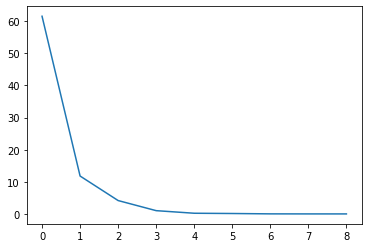

In [10]:
position = np.array([2,7])
#initialize grid cells
gridcells = multi_uniformModules(lam=1000,cell_num_root=100,num_modules=10, s=1.4) #increase cells for more accuracy
#compute firing rate
multi_firing=multi_firing_activity(gridcells,position ,K=50)
#decode position
pos, estimates = decode_2dpos_allm(gridcells,multi_firing)
print(pos)
print(estimates)
mse = np.sum((position - estimates)**2, axis=1)
plt.plot(mse)


mse 0.010989365562586532


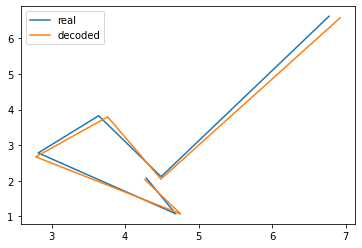

In [ ]:
 # trajectory #1
 #intiailizae trajectory
traject=trajectory_1(6)


#decode position
decoded_traject=decode_2dtraj_allm(traject,gridcells)
plt.figure()
plt.plot(traject[:,0],traject[:,1],label= 'real')
plt.plot(decoded_traject[:,0],decoded_traject[:,1],label='decoded')
plt.legend()

mse=np.sum((decoded_traject-traject)**2)/len(traject)
print('mse', mse)

mse 0.007951938082336607


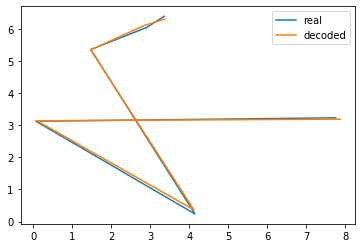

In [ ]:
# trajectory #2 #change seed in trajectory function
traject=trajectory_1(6)

decoded_traject=decode_2dtraj_allm(traject,gridcells)
plt.figure()
plt.plot(traject[:,0],traject[:,1],label= 'real')
plt.plot(decoded_traject[:,0],decoded_traject[:,1],label='decoded')
plt.legend()

mse=np.sum((decoded_traject-traject)**2)/len(traject)
print('mse', mse)

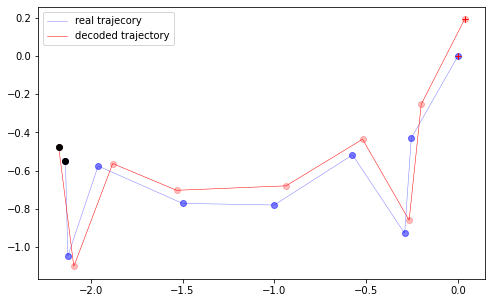

mse 0.013786735031417289


In [ ]:
# trajectory #3 
traject=random_trajectory(total_steps=8) #realistic

decoded_traject=decode_2dtraj_allm(traject,gridcells)

start_real = traject[0,:]
stop_real = traject[-1,:]
start_decoded = decoded_traject[0,:]
stop_decoded = decoded_traject[-1,:]


fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.scatter(traject[:,0], traject[:,1],c='blue',alpha=0.5);
ax.plot(traject[:,0], traject[:,1],c='blue', alpha=0.5,lw=0.5,ls='-',label='real trajecory')
ax.plot(start_real[0], start_real[1],c='red', marker='+')
ax.plot(stop_real[0], stop_real[1],c='black', marker='o')

ax.scatter(decoded_traject[:,0], decoded_traject[:,1],c='red',alpha=0.25);
ax.plot(decoded_traject[:,0], decoded_traject[:,1],c='red', alpha=0.99,lw=0.5,ls='-',label='decoded trajectory')
ax.plot(start_decoded[0], start_decoded[1],c='red', marker='+')
ax.plot(stop_decoded[0], stop_decoded[1],c='black', marker='o')
ax.legend()
plt.show()


mse=np.sum((decoded_traject-traject)**2)/len(traject)
print('mse', mse)

In [ ]:
#We should probably move to a new notebook